In [ ]:
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import warnings
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")

df = pd.read_csv("ltr-quera.csv")

print(df.shape)

(231692, 7)


In [2]:
df.head(7)

,Applicant ID,Job ID,Job Title,Job Level,Remote,Job City,Careers Job - Group Apply Source Job → Title
0,234106.0,19221,کارآموز بوت‌کمپ Golang,intern,False,فردیس,Python Developer Trainee
1,234106.0,19168,کارآموز تست و تضمین کیفیت نرم‌افزار QA,intern,True,فردیس,Python Developer Trainee
2,85372.0,20015,Back-end Developer,senior,False,تهران,توسعه‌دهنده (Back-end (Python
3,85372.0,20172,Back-end Developer,senior,True,تهران,توسعه‌دهنده (Back-end (Python
4,85372.0,20092,Back-end Developer (Python),junior,True,تهران,توسعه‌دهنده (Back-end (Python
5,149261.0,19784,توسعه‌دهنده Back-end,senior,False,تهران,توسعه‌دهنده (Back-end (Python
6,149261.0,19902,برنامه‌نویس (VB6) Back-end,junior,False,تهران,توسعه‌دهنده (Back-end (Python


In [ ]:
df.drop(["Careers Job - Group Apply Source Job → Title"], axis=1, inplace=True)

In [4]:
df.dropna(inplace=True)
df.head()

,Applicant ID,Job ID,Job Title,Job Level,Remote,Job City
0,234106.0,19221,کارآموز بوت‌کمپ Golang,intern,False,فردیس
1,234106.0,19168,کارآموز تست و تضمین کیفیت نرم‌افزار QA,intern,True,فردیس
2,85372.0,20015,Back-end Developer,senior,False,تهران
3,85372.0,20172,Back-end Developer,senior,True,تهران
4,85372.0,20092,Back-end Developer (Python),junior,True,تهران


In [ ]:
df = df.groupby("Job City").filter(lambda x: len(x) >= 50)
df_filtered = df.groupby("Applicant ID").filter(lambda x: len(x) >= 20)
df = df_filtered.groupby("Job ID").filter(lambda x: len(x) >= 5)

In [ ]:
normalization_map = {
    # --- Roles / نقش‌ها ---
    "برنامه نویس": "developer",
    "برنامه‌نویس": "developer",
    "برنامه نویسی": "developer",
    "برنامه‌نویسی": "developer",
    "توسعه دهنده": "developer",
    "توسعه‌دهنده": "developer",
    "مهندس نرم افزار": "software engineer",
    "مهندس نرم‌افزار": "software engineer",
    "کارشناس نرم افزار": "software specialist",
    "کارشناس نرم‌افزار": "software specialist",
    "توسعه دهنده نرم افزار": "software developer",
    "توسعه‌دهنده نرم‌افزار": "software developer",
    "پشتیبان": "support",
    "تحلیلگر": "analyst",
    "تحلیل گر": "analyst",
    "طراح": "designer",
    "مدیر": "manager",
    "متخصص": "specialist",
    "کارشناس": "specialist",
    # --- Levels / سطوح ---
    "ارشد": "senior",
    "سنیور": "senior",
    "جونیور": "junior",
    "کارآموز": "intern",
    "کاراموز": "intern",
    "تازه کار": "junior",
    "تازهکار": "junior",
    "میدلول": "mid-level",
    "mid level": "mid-level",
    # --- Technologies & Fields / تکنولوژی‌ها و حوزه‌ها ---
    "موبایل": "mobile",
    "تحلیل": " analysis",
    "تحلیلگر داده": "data analyst",
    "ساینس": "science",
    "ساینتیست": "scientist",
    "وب": "web",
    "لاراول": "laravel",
    "نرم‌افزار": "software",
    "جنگو": "django",
    "پایتون": "python",
    "جاوااسکریپت": "javascript",
    "جاوا اسکریپت": "javascript",
    "پی اچ پی": "php",
    "پی‌اچ‌پی": "php",
    "سی شارپ": "c#",
    "سی‌شارپ": "c#",
    "دات نت": ".net",
    "دات‌نت": ".net",
    "فرانت اند": "frontend",
    "فرانت‌اند": "frontend",
    "بک اند": "backend",
    "بک‌اند": "backend",
    "فول استک": "fullstack",
    "دواپس": "devops",
    "دوآپس": "devops",
    "هوش مصنوعی": "artificial intelligence",
    "یادگیری ماشین": "machine learning",
    "دیتا": "data",
    "داده": "data",
    "ساینتیست": "scientist",
    "دانشمند": "scientist",
    "علم داده": "data science",
    "اندروید": "android",
    "آی او اس": "ios",
    "آی‌او‌اس": "ios",
    "موبایل": "mobile",
    "امنیت": "security",
    "شبکه": "network",
    "اس کیو ال": "sql",
    "پایگاه داده": "database",
    "داده": "data",
    "دورکاری": "intern",
    "-": "",
    "ك": "ک",  # کاف عربی به فارسی
    "ي": "ی",  # یای عربی به فارسی
}


condition = df["Job Title"].str.contains("remote", case=False, na=False) & (
    df["Remote"] == False
)

# ۲. به‌روزرسانی ستون Remote برای این ردیف‌ها
df.loc[condition, "Remote"] = True


df.loc[df["Remote"] == True, "Job Title"] = (
    df.loc[df["Remote"] == True, "Job Title"]
    .str.replace(r"\b(remote)\b", "", case=False, regex=True)
    .str.replace(r"[()]", "", regex=True)  # حذف پرانتزهای باقی‌مانده
    .str.strip()
)

level_map = {
    "senior": ["senior", "ارشد"],
    "junior": ["junior", "جونیور"],
    "intern": ["intern", "کارآموز", "کاراموز"],
    "manager": ["manager"],
}

# حلقه برای هر سطح شغلی (senior, junior, intern)
for standard_level, keywords in level_map.items():
    regex_pattern = "|".join(keywords)
    condition = df["Job Title"].str.contains(regex_pattern, case=False, na=False) & (
        df["Job Level"] != standard_level
    )

    df.loc[condition, "Job Level"] = standard_level

import re


def normalize_title(title):
    if not isinstance(title, str):
        return ""  # یا هر مقدار پیش‌فرض دیگر برای داده‌های غیرمتنی

    title = title.lower()
    for key, value in normalization_map.items():
        title = title.replace(key, value)
    title = re.sub(r"\s+", " ", title).strip()

    return title


original_title_column = "Job Title"
normalized_title_column = "Job Title"

df[normalized_title_column] = df[original_title_column].apply(normalize_title)

ai_data_keywords = [
    "data scientist",
    "دانشمند داده",
    "data analyst",
    "تحلیلگر داده",
    "data engineer",
    "مهندس داده",
    "machine learning",
    "یادگیری ماشین",
    "business intelligence",
    "هوش تجاری",
    "bi developer",
    "artificial intelligence",
    "هوش مصنوعی",
    "deep learning",
    "یادگیری عمیق",
    "nlp",
    "computer vision",
    "بینایی ماشین",
    "data mining",
    "داده کاوی",
    "big data",
    "tensorflow",
    "pytorch",
    "keras",
    "scikit-learn",
    "pandas",
    "sql",
    "power bi",
    "tableau",
]

backend_keywords = [
    "backend",
    "back-end",
    "بک اند",
    "django",
    "flask",
    "fastapi",
    "laravel",
    "symfony",
    "spring",
    "ruby on rails",
    "rails",
    "python",
    "php",
    "java",
    "go",
    "ruby",
    "rust",
    "nodejs",
    "node.js",
    ".net",
    "c#",
    "graphql",
    "rest api",
]

frontend_keywords = [
    "frontend",
    "front-end",
    "فرانت اند",
    "javascript",
    "js",
    "typescript",
    "react",
    "vue",
    "angular",
    "svelte",
    "css",
    "html",
    "web developer",
]

mobile_keywords = [
    "mobile",
    "موبایل",
    "android",
    "اندروید",
    "ios",
    "swift",
    "kotlin",
    "کاتلین",
    "flutter",
    "react native",
    "jetpack",
    "compose",
    "native",
]

devops_keywords = [
    "devops",
    "ci/cd",
    "docker",
    "kubernetes",
    "aws",
    "azure",
    "gcp",
    "terraform",
    "automation",
]

uiux_keywords = [
    "ui/ux",
    "ui",
    "ux",
    "product designer",
    "designer",
    "دیزاینر",
    "figma",
    "طراح محصول",
]


def get_job_domain(title):
    """
    نسخه نهایی و کامل برای دسته‌بندی شغل‌ها به حوزه‌های اصلی.
    """
    title_lower = str(title).lower()

    # استفاده از re.search با \b برای تطابق کلمه کامل و افزایش دقت
    # ترتیب بررسی بسیار مهم است

    if any(
        re.search(r"\b" + re.escape(keyword) + r"\b", title_lower)
        for keyword in ai_data_keywords
    ):
        return "AI_Data"

    if any(
        re.search(r"\b" + re.escape(keyword) + r"\b", title_lower)
        for keyword in mobile_keywords
    ):
        return "Mobile"

    if any(
        re.search(r"\b" + re.escape(keyword) + r"\b", title_lower)
        for keyword in frontend_keywords
    ):
        return "Frontend"

    if any(
        re.search(r"\b" + re.escape(keyword) + r"\b", title_lower)
        for keyword in backend_keywords
    ):
        return "Backend"

    if any(
        re.search(r"\b" + re.escape(keyword) + r"\b", title_lower)
        for keyword in devops_keywords
    ):
        return "DevOps"

    if any(
        re.search(r"\b" + re.escape(keyword) + r"\b", title_lower)
        for keyword in uiux_keywords
    ):
        return "UI/UX"

    return "Other"


# تابع بالا را در کد خود جایگزین کنید.

# **مهم:** این تابع را به کد خود اضافه کنید.

# این خط را به بخش آماده‌سازی داده خود اضافه کنید
df["Job Domain"] = df["Job Title"].apply(get_job_domain)


ai_ml_keywords = [
    "machine learning",
    "یادگیری ماشین",
    "artificial intelligence",
    "هوش مصنوعی",
    "deep learning",
    "یادگیری عمیق",
    "computer vision",
    "بینایی ماشین",
    "nlp",
    "natural language processing",
    "پردازش زبان طبیعی",
    "data scientist",
    "دانشمند داده",
    "tensorflow",
    "pytorch",
    "keras",
    "scikit-learn",
    "مهندس داده",
    "data engineer",
]

data_analysis_keywords = [
    "data analyst",
    "تحلیلگر داده",
    "business intelligence",
    "هوش تجاری",
    "bi developer",
    "power bi",
    "powerbi",
    "tableau",
    "qlik",
    "ssis",
    "ssas",
    "data visualization",
    "reporting",
    "dashboard",
    "گزارش",
    "داشبورد",
    "بصری سازی داده",
    "data scraping",
    "web scraping",
    "داده کاوی",
    "data mining",
]

# لیست تکنولوژی‌های عمومی (مرتب‌شده)
key_technologies_ordered = [
    "react",
    "vue",
    "angular",
    "svelte",
    "django",
    "flask",
    "fastapi",
    "laravel",
    "symfony",
    "spring",
    "ruby on rails",
    "veujs",
    "viu.js",
    "nodejs",
    "node.js",
    ".net",
    "net.",
    "c#",
    "swift",
    "kotlin",
    "flutter",
    "react native",
    "python",
    "javascript",
    "js",
    "php",
    "java",
    "go",
    "ruby",
    "docker",
    "kubernetes",
    "aws",
    "azure",
]

# دیکشنری نرمال‌سازی
tech_normalization_map = {
    "node.js": "nodejs",
    "javascript": "js",
    ".net": "dotnet",
    "net.": "dotnet",
    "c#": "csharp",
    "viujs": "vue",
    "viu.js": "vue",
}


def extract_final_tech(title):
    """
    تابع نهایی که ابتدا حوزه هوش مصنوعی و سپس سایر تکنولوژی‌ها را بررسی می‌کند.
    """
    title_lower = str(title).lower()

    for keyword in ai_ml_keywords:
        if re.search(r"\b" + re.escape(keyword) + r"\b", title_lower):
            return "ai_ml"

    for keyword in data_analysis_keywords:
        if re.search(r"\b" + re.escape(keyword) + r"\b", title_lower):
            return "data_analysis"

    # مرحله ۲: بررسی سایر تکنولوژی‌هاS
    for tech in key_technologies_ordered:
        if re.search(r"\b" + re.escape(tech) + r"\b", title_lower):
            return tech_normalization_map.get(tech, tech)

    return "unknown"


# --- نحوه استفاده در پروژه ---
df["Technology"] = df["Job Title"].apply(extract_final_tech)

In [ ]:
# ادامه مهندسی ویژگی و پیش پردازش داده ها...
print("۳. ساخت پروفایل‌های استاتیک کاربر و شغل...")

user_profiles = (
    df.groupby("Applicant ID")
    .agg(
        user_preferred_level=("Job Level", lambda x: x.mode().iloc[0]),
        user_preferred_city=("Job City", lambda x: x.mode().iloc[0]),
        user_preferred_domain=("Job Domain", lambda x: x.mode().iloc[0]),
        user_preferred_tech=("Technology", lambda x: x.mode().iloc[0]),
        user_remote_interest_pct=("Remote", "mean"),
    )
    .reset_index()
)

job_features = df.drop_duplicates(subset=["Job ID"])[
    [
        "Job ID",
        "Job Title",
        "Job Level",
        "Job City",
        "Remote",
        "Job Domain",
        "Technology",
    ]
]

۳. ساخت پروفایل‌های استاتیک کاربر و شغل...


In [ ]:
df.shape

(103805, 8)

In [ ]:
user_ids = df["Applicant ID"].astype("category").cat.codes
job_ids_cat = df["Job ID"].astype("category").cat.codes
interaction_matrix = csr_matrix((np.ones(len(df)), (user_ids, job_ids_cat)))

# محاسبه ماتریس شباهت آیتم-آیتم
item_similarity_matrix = cosine_similarity(interaction_matrix.T)

# ساخت دیکشنری برای نگاشت ID به ایندکس ماتریس و برعکس
job_id_map = dict(
    zip(
        df["Job ID"].astype("category").cat.categories,
        range(len(df["Job ID"].astype("category").cat.categories)),
    )
)
job_id_map_inv = {v: k for k, v in job_id_map.items()}


def generate_candidates_ibcf(user_id, user_applied_jobs_map, n_candidates=200):
    user_history_ids = user_applied_jobs_map.get(user_id, set())
    if not user_history_ids:
        return []

    user_history_indices = [
        job_id_map[jid] for jid in user_history_ids if jid in job_id_map
    ]
    if not user_history_indices:
        return []

    # محاسبه میانگین امتیاز شباهت برای تمام شغل‌ها
    similar_scores = item_similarity_matrix[user_history_indices].mean(axis=0)

    # مرتب‌سازی و انتخاب بهترین‌ها
    top_indices = np.argsort(similar_scores)[::-1][
        : n_candidates + len(user_history_ids)
    ]

    # تبدیل ایندکس‌ها به Job ID و حذف شغل‌های قبلاً دیده شده
    candidate_ids = [
        job_id_map_inv[idx] for idx in top_indices if idx in job_id_map_inv
    ]
    candidate_ids = [jid for jid in candidate_ids if jid not in user_history_ids]

    return candidate_ids[:n_candidates]

In [ ]:
positive_interactions = df.copy()  # استفاده از کل دیتافریم برای نگه داشتن ویژگی‌ها
positive_interactions["relevance"] = 1

all_jobs_ids = df["Job ID"].unique()
user_applied_jobs = df.groupby("Applicant ID")["Job ID"].apply(set)

negative_samples = []
num_domain_negatives = 2
num_tech_negatives = 2
num_dissimilar_negatives = 2  # جدید: تعداد نمونه‌های ناشبیه از IBCF
num_easy_negatives = 1

all_jobs_df = job_features.set_index("Job ID")

for user_id, applied_jobs_set in user_applied_jobs.items():
    # استخر کاندیداها برای این کاربر
    non_applied_ids = np.setdiff1d(all_jobs_ids, list(applied_jobs_set))
    candidate_pool_df = all_jobs_df.loc[non_applied_ids]

    # --- بخش جدید: پیدا کردن ۲ نمونه ناشبیه با IBCF ---
    try:
        user_history_indices = [
            job_id_map[jid] for jid in applied_jobs_set if jid in job_id_map
        ]
        if user_history_indices:
            # محاسبه میانگین امتیاز شباهت
            similar_scores = item_similarity_matrix[user_history_indices].mean(axis=0)

            # پیدا کردن ناشبیه‌ترین آیتم‌ها (با کمترین امتیاز شباهت)
            dissimilar_indices = np.argsort(similar_scores)

            dissimilar_negs_ids = []
            for idx in dissimilar_indices:
                job_id_candidate = job_id_map_inv.get(idx)
                # اطمینان از اینکه کاندیدا در لیست شغل‌های اپلای شده کاربر نباشد
                if job_id_candidate and job_id_candidate in non_applied_ids:
                    dissimilar_negs_ids.append(job_id_candidate)
                    if len(dissimilar_negs_ids) >= num_dissimilar_negatives:
                        break

            for neg_id in dissimilar_negs_ids:
                negative_samples.append({"Applicant ID": user_id, "Job ID": neg_id})
    except (KeyError, IndexError):
        pass  # اگر مشکلی در IBCF بود، از این بخش رد شو

    # --- بخش نمونه‌گیری سخت (Hard Negative Sampling) ---
    for job_id in applied_jobs_set:
        try:
            positive_job = all_jobs_df.loc[job_id]
            pos_domain = positive_job["Job Domain"]
            pos_level = positive_job["Job Level"]
            pos_tech = positive_job["Technology"]

            found_negs_for_this_pos = []

            domain_candidates = candidate_pool_df[
                #  (candidate_pool_df['Job Level'] == pos_level) &
                (candidate_pool_df["Job Domain"] != pos_domain)
            ]
            n_domain = min(len(domain_candidates), num_domain_negatives)
            if n_domain > 0:
                domain_negs_ids = list(
                    np.random.choice(
                        domain_candidates.index.tolist(), n_domain, replace=False
                    )
                )
                found_negs_for_this_pos.extend(domain_negs_ids)

            # --- نمونه سخت مبتنی بر Technology ---
            tech_candidate_pool_df = candidate_pool_df[
                ~candidate_pool_df.index.isin(found_negs_for_this_pos)
            ]
            if pos_tech != "unknown":
                tech_candidates = tech_candidate_pool_df[
                    # (tech_candidate_pool_df['Job Level'] == pos_level) &
                    (tech_candidate_pool_df["Technology"] != pos_tech)
                    & (tech_candidate_pool_df["Technology"] != "unknown")
                ]
                n_tech = min(len(tech_candidates), num_tech_negatives)
                if n_tech > 0:
                    tech_negs_ids = list(
                        np.random.choice(
                            tech_candidates.index.tolist(), n_tech, replace=False
                        )
                    )
                    found_negs_for_this_pos.extend(tech_negs_ids)

            # اضافه کردن نمونه‌های سخت یافت‌شده
            for neg_id in set(found_negs_for_this_pos):
                negative_samples.append({"Applicant ID": user_id, "Job ID": neg_id})

            # --- نمونه آسان (تصادفی) ---
            easy_candidates = candidate_pool_df[
                ~candidate_pool_df.index.isin(found_negs_for_this_pos)
            ]
            if len(easy_candidates) > 0:
                num_to_sample = min(len(easy_candidates), num_easy_negatives)
                easy_negs_ids = list(
                    np.random.choice(
                        easy_candidates.index.tolist(), num_to_sample, replace=False
                    )
                )
                for neg_id in easy_negs_ids:
                    negative_samples.append({"Applicant ID": user_id, "Job ID": neg_id})

        except (KeyError, IndexError):
            continue

negative_interactions = pd.DataFrame(negative_samples).drop_duplicates()
negative_interactions["relevance"] = 0

print(
    f"نمونه‌گیری منفی به پایان رسید. تعداد نمونه‌های منفی تولید شده: {len(negative_interactions)}"
)

نمونه‌گیری منفی به پایان رسید. تعداد نمونه‌های منفی تولید شده: 395026


In [ ]:
negative_interactions_featured = pd.merge(
    negative_interactions, job_features, on="Job ID", how="left"
)

df_final = pd.concat(
    [positive_interactions, negative_interactions_featured], ignore_index=True
)

df_final = pd.merge(df_final, user_profiles, on="Applicant ID", how="left")


df_final.dropna(
    subset=["Job Title", "user_preferred_level"], inplace=True
)  # می‌توانید ستون‌های کلیدی را مشخص کنید


print("ساخت دیتافریم نهایی به پایان رسید.")

print("ستون‌های موجود در df_final:", df_final.columns.tolist())

ساخت دیتافریم نهایی به پایان رسید.
ستون‌های موجود در df_final: ['Applicant ID', 'Job ID', 'Job Title', 'Job Level', 'Remote', 'Job City', 'Job Domain', 'Technology', 'relevance', 'user_preferred_level', 'user_preferred_city', 'user_preferred_domain', 'user_preferred_tech', 'user_remote_interest_pct']


In [ ]:
df_final["interaction_level_match"] = (
    df_final["Job Level"] == df_final["user_preferred_level"]
).astype(int)

df_final["interaction_city_match"] = (
    df_final["user_preferred_city"] == df_final["Job City"]
).astype(int)

df_final["interaction_domain_match"] = (
    df_final["Job Domain"] == df_final["user_preferred_domain"]
).astype(int)

df_final["interaction_tech_match"] = (
    df_final["Technology"] == df_final["user_preferred_tech"]
).astype(int)

# ساخت ویژگی‌های باینری و One-hot

df_final = pd.concat(
    [df_final, pd.get_dummies(df_final["Job Level"], prefix="level")], axis=1
)

In [ ]:
key_technologies = [
    "python",
    "django",
    "flask",
    "fastapi",
    "flutter",
    "java",
    "swift",
    "kotlin",
    "javascript",
    "react",
    "vue",
    "angular",
    "php",
    "laravel",
    "symfony",
    "c#",
    ".net",
    "java",
    "spring",
    "go",
    "ruby",
    "react",
    "js",
    "nodejs",
]

for tech in key_technologies:
    column_name = f"is_{tech.replace('.', '_').replace(' ', '_')}"
    df_final[column_name] = (
        df_final["Job Title"].str.contains(tech, case=False, regex=False).astype(int)
    )


df_final.loc[df_final["is_javascript"] == 1, "is_js"] = 1
feature_cols = [
    "Remote",
    "user_remote_interest_pct",
    "interaction_level_match",
    "interaction_city_match",
    "interaction_domain_match",
    "interaction_tech_match",
    "level_intern",
    "level_junior",
    "level_manager",
    "level_senior",
    "is_python",
    "is_django",
    "is_flask",
    "is_fastapi",
    "is_flutter",
    "is_java",
    "is_swift",
    "is_kotlin",
    "is_react",
    "is_vue",
    "is_angular",
    "is_php",
    "is_laravel",
    "is_symfony",
    "is_c#",
    "is__net",
    "is_spring",
    "is_go",
    "is_ruby",
    "is_js",
    "is_nodejs",
]

feature_cols = [col for col in feature_cols if col in df_final.columns]

In [ ]:
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df_final["Job Title"])

In [ ]:
X_dense = df_final[feature_cols].astype(float)
X = hstack([X_dense, tfidf_matrix]).tocsr()
y = df_final["relevance"]

# ساخت گروه‌ها
df_final = df_final.sort_values("Applicant ID")
groups = df_final.groupby("Applicant ID").size().to_numpy()
query_ids = df_final["Applicant ID"]

# به‌روزرسانی X و y برای هماهنگی با ترتیب جدید
X = X[df_final.index]
y = y[df_final.index]

In [ ]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=query_ids))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_groups = df_final.iloc[train_idx].groupby("Applicant ID").size().to_numpy()
test_groups = df_final.iloc[test_idx].groupby("Applicant ID").size().to_numpy()

In [ ]:
ranker = lgb.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.7,  # مهم: جلوگیری از تسلط یک ویژگی
    lambda_l1=0.1,
    lambda_l2=0.1,
)


ranker.fit(
    X=X_train,
    y=y_train,
    group=train_groups,
    eval_set=[(X_test, y_test)],
    eval_group=[test_groups],
    eval_at=[10],
    callbacks=[lgb.early_stopping(200, verbose=True)],
)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3350
[LightGBM] [Info] Number of data points in the train set: 402092, number of used features: 128
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Training until validatio

LGBMRanker(colsample_bytree=0.7, lambda_l1=0.1, lambda_l2=0.1,
           learning_rate=0.05, metric='ndcg', n_estimators=1000, n_jobs=-1,
           objective='lambdarank', random_state=42)

In [19]:
ranker.evals_result_

{'valid_0': OrderedDict([('ndcg@10',
               [0.6811739466456833,
                0.8540967536194761,
                0.8658964215539915,
                0.8684623205264314,
                0.8708852783580475,
                0.8721327450728786,
                0.8732186801328903,
                0.8738632829358546,
                0.8743815419168305,
                0.8750566921720067,
                0.8748045197967285,
                0.8747967450571325,
                0.8761145735266528,
                0.8767123872766591,
                0.8760488250836538,
                0.8762407594293037,
                0.8770635203813814,
                0.8764478314868817,
                0.8765381090039346,
                0.8767957056505032,
                0.8774238168121556,
                0.8773330848299711,
                0.8772536824380286,
                0.8772380027092634,
                0.876929479611784,
                0.8766880609648211,
                0.8765252603

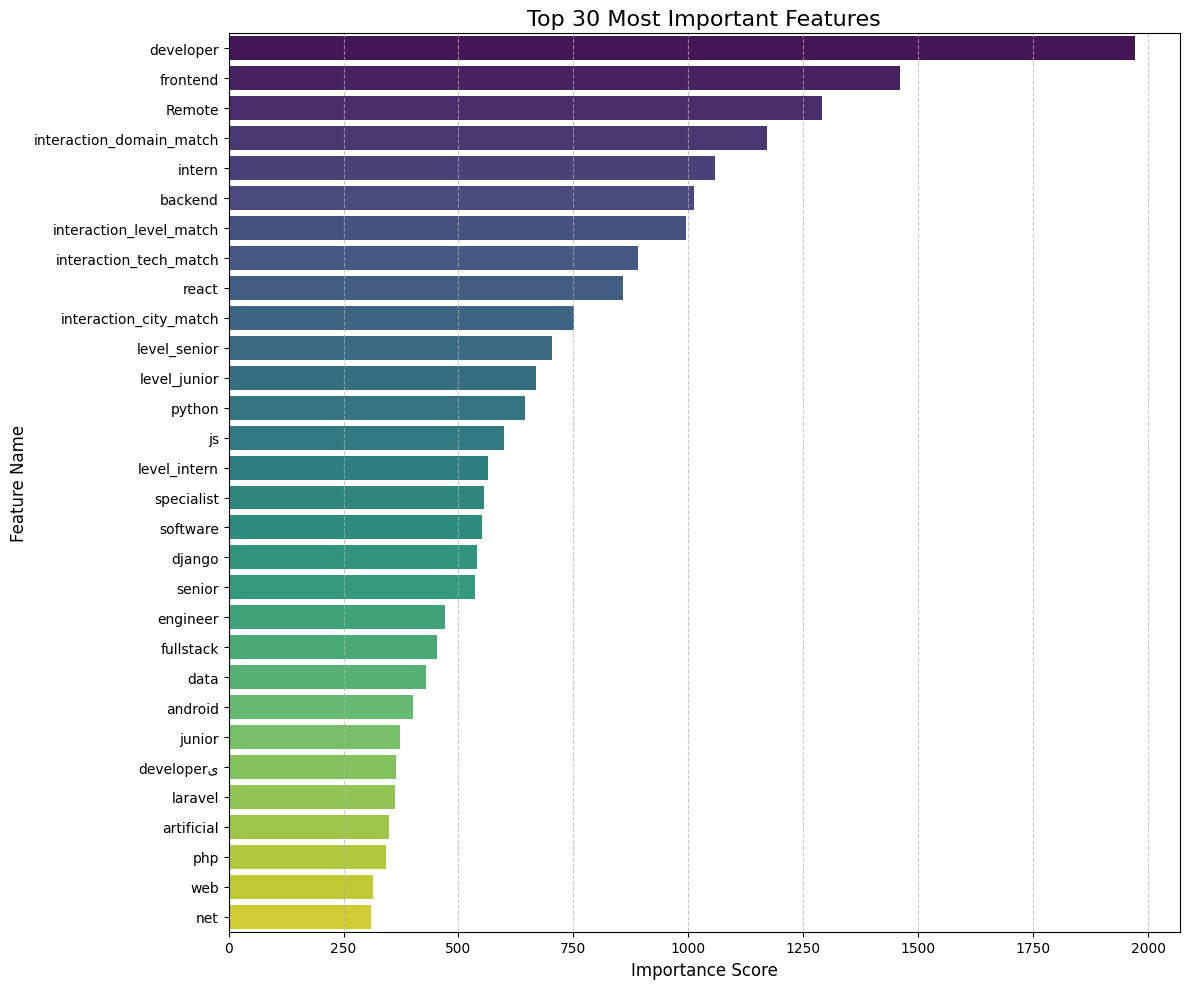

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


importances = ranker.feature_importances_

tfidf_feature_names = vectorizer.get_feature_names_out()
all_feature_names = feature_cols + list(tfidf_feature_names)

feature_importance_df = pd.DataFrame(
    {"feature": all_feature_names, "importance": importances}
)

sorted_df = feature_importance_df.sort_values(
    by="importance", ascending=False
).reset_index(drop=True)


plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=sorted_df.head(30), palette="viridis")
plt.title("Top 30 Most Important Features", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()  # برای جلوگیری از بریده شدن نام ویژگی‌ها
plt.show()

In [ ]:
import pandas as pd



def show_applied_jobs(user_id, df_original, df_job_features):
    """

    برای یک کاربر مشخص، لیست آگهی‌هایی را که قبلاً برایشان رزومه فرستاده، نمایش می‌دهد.


    Args:

        user_id (int): شناسه کاربر.

        df_original (pd.DataFrame): دیتافریم اصلی شامل تمام تعاملات.

        df_job_features (pd.DataFrame): دیتافریم شامل جزئیات هر شغل.
    """

    print(f"در حال بررسی تاریخچه رزومه‌های ارسال شده برای کاربر: {user_id}\n")


    # ۱. فیلتر کردن دیتافریم اصلی برای یافتن ردیف‌های مربوط به کاربر

    user_applications = df_original[df_original["Applicant ID"] == user_id]


    # ۲. بررسی اینکه آیا کاربر اصلاً رزومه‌ای ارسال کرده است یا نه

    if user_applications.empty:

        print(f"کاربر با شناسه {user_id} تا به حال برای هیچ آگهی رزومه نفرستاده است.")
        return


    # ۳. استخراج شناسه‌های منحصر به فرد شغل‌ها

    applied_job_ids = user_applications["Job ID"].unique()


    # ۴. یافتن جزئیات این شغل‌ها از دیتافریم ویژگی‌های شغل

    applied_jobs_details = df_job_features[
        df_job_features["Job ID"].isin(applied_job_ids)
    ]


    # ۵. نمایش نتیجه

    print(f"✅ لیست آگهی‌هایی که کاربر {user_id} قبلاً برای آنها رزومه فرستاده است:\n")

    print(
        applied_jobs_details[
            ["Job ID", "Job Title", "Job Level", "Job City", "Job Domain", "Technology"]
        ]
    )

    return applied_jobs_details



if "df" in locals() and "job_features" in locals() and "sample_user_id" in locals():

    # فراخوانی تابع برای نمایش تاریخچه همان کاربر

    hf = show_applied_jobs(user_id=156289, df_original=df, df_job_features=job_features)

else:

    print("لطفاً ابتدا متغیرهای لازم (df, job_features, sample_user_id) را آماده کنید.")

لطفاً ابتدا متغیرهای لازم (df, job_features, sample_user_id) را آماده کنید.


In [ ]:
def generate_hybrid_recommendations_final(
    user_id,
    # مدل‌ها و داده‌های مورد نیاز
    ranker_model,
    ibcf_candidates_func,
    user_applied_jobs_map,
    job_features_df,
    user_profiles_df,
    vectorizer_model,
    feature_cols_list,
    # پارامترها
    n_candidates=50,
    top_n=10,
):
    """
    یک پایپ‌لاین کامل هیبریدی که ابتدا کاندیدا تولید کرده و سپس آنها را رتبه‌بندی می‌کند.
    """
    print(f"\n--- شروع فرآیند پیشنهاد هیبریدی برای کاربر {user_id} ---")

    # --- مرحله ۱: تولید کاندیدا با IBCF ---
    print(f"مرحله ۱: تولید {n_candidates} کاندیدا با IBCF...")
    candidate_ids = ibcf_candidates_func(user_id, user_applied_jobs_map, n_candidates)

    if not candidate_ids:
        print("کاندیدایی توسط IBCF یافت نشد.")
        return pd.DataFrame(), pd.DataFrame()  # برگرداندن دو دیتافریم خالی

    # دیتافریم کاندیداهای اولیه برای بازگرداندن
    ibcf_candidates_df = job_features_df[
        job_features_df["Job ID"].isin(candidate_ids)
    ].copy()
    print(f"تعداد کاندیداهای یافت شده: {len(ibcf_candidates_df)}")

    # --- مرحله ۲: آماده‌سازی داده‌ها برای رتبه‌بندی ---
    print("مرحله ۲: ساخت ویژگی‌ها برای مدل LTR...")
    df_to_rank = ibcf_candidates_df.copy()

    user_profile = user_profiles_df[user_profiles_df["Applicant ID"] == user_id]
    if user_profile.empty:
        print(f"پروفایل کاربر {user_id} یافت نشد.")
        return ibcf_candidates_df, pd.DataFrame()

    df_to_rank["Applicant ID"] = user_id
    df_to_rank = pd.merge(df_to_rank, user_profile, on="Applicant ID", how="left")

    # محاسبه تمام ویژگی‌های تعاملی و دیگر ویژگی‌ها در لحظه
    # این بخش باید دقیقاً مشابه منطق زمان آموزش باشد
    df_to_rank["interaction_level_match"] = (
        df_to_rank["Job Level"] == df_to_rank["user_preferred_level"]
    ).astype(int)
    df_to_rank["interaction_city_match"] = (
        df_to_rank["user_preferred_city"] == df_to_rank["Job City"]
    ).astype(int)
    df_to_rank["interaction_domain_match"] = (
        df_to_rank["Job Domain"] == df_to_rank["user_preferred_domain"]
    ).astype(int)
    # ... و سایر ویژگی‌های تعاملی مانند hierarchical_match_score اگر ساخته‌اید ...

    df_to_rank = pd.concat(
        [df_to_rank, pd.get_dummies(df_to_rank["Job Level"], prefix="level")], axis=1
    )

    # آماده‌سازی ماتریس ویژگی‌ها برای پیش‌بینی
    df_to_rank["normal_title"] = df_to_rank["Job Title"].apply(normalize_title)

    # استفاده از reindex برای تضمین وجود و ترتیب صحیح ستون‌ها
    X_dense_pred = df_to_rank.reindex(columns=feature_cols_list, fill_value=0).astype(
        float
    )
    X_tfidf_pred = vectorizer_model.transform(df_to_rank["normal_title"])

    X_pred = hstack([X_dense_pred, X_tfidf_pred]).tocsr()

    # --- مرحله ۳: پیش‌بینی و رتبه‌بندی نهایی ---
    print("مرحله ۳: امتیازدهی و رتبه‌بندی نهایی...")
    scores = ranker_model.predict(X_pred)
    df_to_rank["score"] = scores

    final_recommendations = df_to_rank.sort_values("score", ascending=False).head(top_n)

    return final_recommendations, ibcf_candidates_df